<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/14_Pro_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Pro

Макс 10 баллов

Добейтесь точности распознавания 97% и верно распознанных всех писателей с помощью любой нейронной сети. 

Подсказка: Попробуйте менять размер окна и шаг.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Sep 27 04:31:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import of libraries

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer  #Метод для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences #Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder #Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split #Метод для разделения выборки на обучающую и тестовую

from google.colab import drive
import time #Импортируем библеиотеку time

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Classification of writter's texts

Loading data

In [ ]:
#Собираем данные через функцию, которая читает данные
#На вход подаем путь к файлу, открываем файл в режиме чтения
# переносы строки меняем на пробелы
# возвращаем текст файла
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace('\n', ' ')

  return text

# Объявляем классы и считаем кол-во классов
className = ['О. Генри', 'Стругацкие', 'Булгаков', ' Саймак', 'Фрай', 'Брэдберри']
nClasses = len(className)

# Итак, мы растянули весь текст в одну строку

In [ ]:
#Загружаем обучающие тексты

trainText = []
testText = []

#Создаем выборку по условию:
#Класс каждого i-го элемента в обучающей выборке должен соответствовать
#классу каждого i-го элемента тестовой выборки

# Обходим классы
for i in className:
  # пробегаемся по всем документам в папке 'texts'
  for j in os.listdir('texts/'):
    # смотрим содержится ли в названии имя класса, если да , то работаем дальше
    if i in j:
      # Дальше проверяем обучающий это файл или тестовый и добавляем текст в выборку
      if 'Обучающая' in j:
        trainText.append(readText('texts/' + j))
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText('texts/' + j))
        print(j, 'добвлен в тестовую выборку')
print()

      

(О. Генри) Тестовая_20 вместе.txt добвлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Булгаков) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд Саймак) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добвлен в тестовую выборку



In [ ]:
# Посмотрим кол-во элементов в trainText и в первом элементе 
print(len(trainText))
print(len(trainText[0]))

6
1049517


In [ ]:
# Посмотрим кол-во элементов в testText и в первом элементе 
print(len(testText))
print(len(testText[0]))

6
349662


# maxWordsCount , xLen, step

In [ ]:
maxWordsCount = 40000
xLen = 3000 
step = 170 

# Data processing. Converting textual data to numeric and vector for neural network training

In [ ]:
#Tokenizer - функция Keras , которая поможет разделить текст и преобразовать его в матрицу числовых значений
# засекаем время
# cur_time = time.time()
#Для русского языка часто используется параметр 20 000 - кол-во слов/индексов при обучении текста
# maxWordsCount = 10000
#Избавимся от ненужных символов, приводим слова к нижнему регистру и char_level = False - токенизируем по словам
tokenizer = Tokenizer(num_words=maxWordsCount, filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower = True, split=' ', oov_token='unknown', char_level = False)

# Подаем тексты в обработку
tokenizer.fit_on_texts(trainText)
#Выводим интексы слов для просмотра
items = list(tokenizer.word_index.items())
# print('Время обработки: ', round(time.time()-cur_time, 2), 'c', sep='')





In [ ]:
# заменяем слова на индексы - преобразуем текст к числовым значениям
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

# print('Взглянем на фрагмент обучающего текста: ')
# print('В виде оригинального текста:                ', trainText[1][:87])
# print('Он же в виде последовательности индексов:   ', trainWordIndexes[1][:20], '\n')

In [ ]:
# print('Статистика по обучающим текстам  :')

# #Посчитаем слова и символы, для этого объявим переменные
# symbolsTrainText = 0
# wordsTrainTexts = 0

# #обходим все классы, печатаем сколько символов в примере и сколько слов
# for i in range(nClasses):
#   print(className[i], ' '*(10-len(className[i])), len(trainText[i]), 'символов, ',len(trainWordIndexes[i]), 'слов')
#   symbolsTrainText += len(trainText[i])
#   wordsTrainTexts += len(trainWordIndexes[i])

# print('----')
# print('В сумме ', symbolsTrainText, 'символов', wordsTrainTexts, 'слов \n')
# print()
# print("Статистика по тестовым текстам: ")

# symbolsTestText = 0
# wordsTestText = 0 

# for i in range(nClasses):
#   print(className[i], ' '*(10-len(className[i])), len(testText[i]), 'символов, ', len(testWordIndexes[i]), 'слов')
#   symbolsTestText += len(testText[i])
#   wordsTestText += len(testWordIndexes[i])
# print('----')
# print('В сумме ', symbolsTestText, 'символов, ', wordsTestText, 'слов')



# Creation of training and validation samples

In [ ]:
# Напишем функцию, которая получает последовательность индексов, шаг и ширину.
# В xSample заносим примеры
# В wordsLen считаем кол-во символов
# В цикле while будем "откусывать" кусочки из wordIndexes длиной xLen
# По списку индексов слов разделяем на короткие векторы.
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step

  return xSample

# Это функция для одного писателя , а у нас их 6


In [ ]:
# Для этого создаем функцию createSetsMultyClasses, на вход подаем последовательность индексов, размер окна, шаг окна
def createSetsMultiClasses(wordIndexes, xLen, step):
  #Для каждого из 6 классов создаем обучающую и проверочную выборки
  nClasses = len(wordIndexes)
  classesXSamples = []
  # Для каждого текста из последовательности выборки
  for wI in wordIndexes:
    #добавляем в список очередной текст индексов разбиный на (кол-во окон * длину окна)
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  #Создаем один общий xSamples 
  # список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  xSamples = []
  # список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  ySamples = []

  #В диапазоне кол-ва классов (6)
  for t in range (nClasses):
    # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    xT = classesXSamples[t]
    # И каждое его окно добавляем в общий список выборки
    for i in range(len(xT)):
      xSamples.append(xT[i])
      # Добавляем соответствующий вектор класса
      ySamples.append(utils.to_categorical(t, nClasses))

  # переводим в массив для подачи в нейронку
  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
  
  #Функция возвращает выборку и соответствующие векторы классов
  return (xSamples, ySamples)



In [ ]:
# #Задаем параметры переменным 
# #Длина отрезка текста, по которой анализируем, в словах
# xLen = 300 
# #Шаг разбиения исходного текста на обучающие векторы
# step = 30 

In [ ]:
#Засекаем текущее время
# cur_time = time.time()
#извлекаем обучающую и тестовую выборки
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# print('Время обработки : ', round(time.time() - cur_time, 2), 'c', sep='')
#Получили тестовый набор, для Embedding этого достаточно. А для bag of words нужно xTrain и xTest преобразовать в векторы из 0 и 1


(10306, 3000)
(10306, 6)
(3863, 3000)
(3863, 6)


In [ ]:
# Функция sequences_to_matrix переведет наши данные в векторы со значениями 0 и 1
#Засекаем время 
# cur_time = time.time()
#в виде списка, чтобы метод успешно сработал
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

print(xTrain01.shape)
print(xTrain01[0][0:100])
# print('Время обработки: ', round(time.time() - cur_time,2), 'c', sep='')


(10306, 40000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1.]


# Creation and training of a neural network

## relu + softmax 

In [ ]:
#Создаём полносвязную сеть
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов 
model.add(Dense(64, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())

model.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
model.add(BatchNormalization())

# model.add(Dense(32, activation="relu"))
# #Слой регуляризации Dropout
# model.add(Dropout(0.25))
# model.add(BatchNormalization())

#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 64)                2560064   
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 64)                256       
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 64)                256       
_________________________________________________________________
dense_44 (Dense)             (None, 6)               

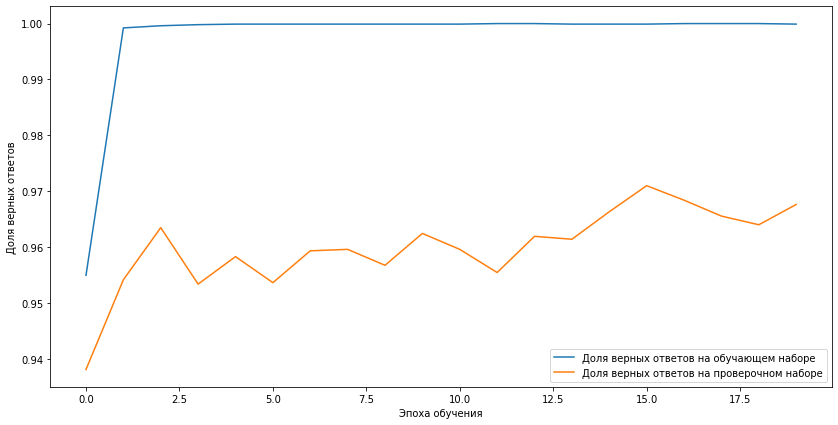

In [ ]:
# Выводим график обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model.save('9676.h5')

На 16 эпохе достигнута точность 97,10 % за счет увеличения словаря до 40 000 слов,длины окна до 3000 , шага до 170 (хотя и на 150 были хорошие результаты). Можно доработать еще , дальше провести эксперименты с длиной окна и размером словаря + уменьшить lr на дообучении, но решила идти дальше по программе. Важно отметить , здесь лучше сработала простая модель сети с 2мя слоями Dense + Dropout+BatchNormalization. 

Я бы хотела уточнить , а возможно обучить нейронку до 97% на параметрах длины окна менее 1000 и на шаге =- 100? Какие варианты по работе с настройками при обучении НС порекомендуете?

Мне потребовалось перейти на платную версию Colab, чтобы получить необходимый ресурс ОЗУ и сэкономить время.